Import important parameter

In [1]:
inputsize =15**2
e = 0.05

Import Package

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import pyamg
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg
from mpl_toolkits.mplot3d import Axes3D
import xlsxwriter
from scipy.ndimage import convolve

Define function

In [3]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))     
    sqrtoutputsize = int(sqrtinputsize/2)
    outputsize = int(sqrtoutputsize**2)
    OUTPUT = np.zeros([outputsize, inputsize])
    for j in range(sqrtoutputsize):
        for i in range(sqrtoutputsize):
            OUTPUT[i+sqrtoutputsize*j][2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][1+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/4
            OUTPUT[i+sqrtoutputsize*j][2+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2*sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2 *
                                       sqrtinputsize + 2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2 *
                                       sqrtinputsize+2*i+j*2*sqrtinputsize] = 1/16
    return OUTPUT

def Poisson(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))     
    sqrtoutputsize = int(sqrtinputsize/2)
    outputsize = int(sqrtoutputsize**2)
    OUTPUT = np.zeros([outputsize, inputsize])
    A1 = 2*np.eye(sqrtinputsize)
    for i in range(sqrtinputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    I = np.eye(sqrtinputsize)
    OUTPUT = (np.kron(I, A1)+np.kron(A1, I))
    return OUTPUT


def Multigrid_circle(inputsize, A_A, B, R_A, s, w, error):
    A = np.matrix(A_A)
    P = 4.*np.transpose(R_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    Residual=1
    i=0
    while Residual > error:
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        i=i+1
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

def optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam):
    rhoold = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    device = torch.device('cpu')
    R = torch.tensor(R,dtype = torch.double, requires_grad=True,device=device)
    w = torch.tensor(w,dtype = torch.double, requires_grad=True, device=device)
    lam = torch.tensor(lam,dtype = torch.double, requires_grad=True, device=device)
    A = torch.tensor(A1,dtype = torch.double, device=device)
    P = 4*torch.t(R)
    M = (w**(-1)) * torch.diag(torch.diag(A))
    K = M - A
    MK = torch.mm(torch.inverse(M),K)
    I = torch.eye(inputsize,dtype = torch.double, device=device)
    I1 = torch.ones([inputsize,1],dtype = torch.double, device=device)
    I2 = torch.ones([outputsize,1],dtype = torch.double, device=device)
    IPRAPRA = I - torch.mm(torch.mm(torch.mm(P,torch.inverse(torch.mm(torch.mm(R,A),P))),R),A)
    C = torch.mm(torch.mm(MK,IPRAPRA),MK)
    for i in range(5):
        C = torch.mm(C,C)
    loss = torch.norm(C)**(1/32) + torch.mm(lam,torch.mm(R,I1) - I2)
    loss.backward()
    with torch.no_grad():
        R-=learning_rate*R.grad
        w-=learning_rate*w.grad 
        lam-=learning_rate*lam.grad
    R = R.detach().numpy()
    w = w.detach().numpy()
    lam = lam.detach().numpy()
    rhonew = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    return R, w, lam, rhoold, rhonew

def direct_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate, lam):
    Rhoold = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    Rhonew = [Rhoold]
    for i in range(100):
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        R = Rnew
        w = wnew
        lam = lamnew
        print("rho = {}".format(rhonew))
        print("===================")
        Rhonew.append(rhonew)
        i+=1
    print("======End======")
    return R, w, Rhoold, Rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate ,accept_radius ,step_length,lam):
    Rhoold = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    Radius = [Rhoold]
    L = step_length
    print("======Section 1======")
    while L < 1:
        M = (1-L)*A0 + L*A1
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, M, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        if rhonew > accept_radius:
            step_length = 0.1*step_length
            learning_rate = 0.1*learning_rate
            print('Decrease the step_length, learning_rate and Restart!!')
            print("step_length = {}".format(step_length))      
            print("learning_rate = {}".format(learning_rate))
            print("rhonew = {}".format(rhonew))
            print("===================")
            R = Restriction(inputsize)
            lam = np.zeros([1,outputsize])
            w = 2/3
            L = step_length
        else:
            R = Rnew
            w = wnew
            L += step_length
            lam = lamnew
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    print("======Section 2======")
    i = 0
    while rhoold>rhonew and i <1000:
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        R = Rnew
        w = wnew
        lam = lamnew
        print("the {} steps".format(i))
        print("rho = {}".format(rhonew))
        print("===================")
        i+=1            
    Rhonew = rhonew
    print("======End======")
    return R, w, Rhoold, Rhonew, Radius

Define parameter

In [4]:
s = 1
w = 2/3
error=10e-11
def u_real(x, y): return np.sin(np.pi*3*x)*np.sin(np.pi*5*y)
def rightf(x, y): return  34*np.pi**2*(1 + (2 + np.cos(np.pi*x))/(2 + np.cos(np.pi*y)) + (2 + np.cos(5*np.pi*x))/(2 + np.cos(5*np.pi*y)))*np.sin(3*np.pi*x)*np.sin(5*np.pi*y) - 3*np.pi*np.cos(3*np.pi*x)*(-((np.pi*np.sin(np.pi*x))/(2 + np.cos(np.pi*y))) - (5*np.pi*np.sin(5*np.pi*x))/(2 + np.cos(5*np.pi*y)))*np.sin(5*np.pi*y) - 5*np.pi*np.cos(5*np.pi*y)*np.sin(3*np.pi*x)*((np.pi*(2 + np.cos(np.pi*x))*np.sin(np.pi*y))/(2 + np.cos(np.pi*y))**2 + (5*np.pi*(2 + np.cos(5*np.pi*x))*np.sin(5*np.pi*y))/(2 + np.cos(5*np.pi*y))**2)
def a(x,y): return(1 + (2 + np.cos(np.pi*x))/(2 + np.cos(np.pi*y)) + (2 + np.cos(5*np.pi*x))/(2 + np.cos(5*np.pi*y)))

sqrtinputsize = int(np.sqrt(inputsize))     
sqrtoutputsize = int(sqrtinputsize/2)
outputsize = int(sqrtoutputsize**2)
h = 1/(sqrtinputsize-1)
H = 1/(sqrtoutputsize-1)
A0 = Poisson(inputsize)
num_levels=2
n=sqrtinputsize
kx = np.zeros([n,n+1])
ky = np.zeros([n+1,n])
for i in range(n):
    for j in range(n+1):
        kx[i][j] = a((j-0.5)*h,i*h)
for i in range(n+1):
    for j in range(n):
        ky[i][j] = a(j*h,(i-0.5)*h)    
A1 = gallery.nonlinearPoisson((n,n), kx, ky)
n = inputsize
linear_gmg = gmg_linear.LinearGMG(A1, max_levels=num_levels)
print("Linear = {}".format(linear_gmg.compute_rho()))
[X, Y] = np.meshgrid(np.linspace(0, 1, sqrtinputsize),np.linspace(0, 1, sqrtinputsize))
RightF = rightf(X,Y)*h**2
RightF = RightF.reshape(inputsize, 1)
Ureal = u_real(X,Y).reshape(inputsize, 1)
Media = a(X,Y)
R = Restriction(inputsize)
P = 4*np.transpose(R)

Linear = 0.19347856438354813


GMM on fine grid

In [5]:
GMM_U, GMM_Res = Multigrid_circle(inputsize, A1.to_full(), RightF, R, s, w, error)

Residual = 30.29328610244206
Interation = 1
Residual = 5.835339799422145
Interation = 2
Residual = 1.826397846805404
Interation = 3
Residual = 0.6039151435859931
Interation = 4
Residual = 0.20741639972709003
Interation = 5
Residual = 0.07305774067478064
Interation = 6
Residual = 0.026157586999321594
Interation = 7
Residual = 0.009470046494651444
Interation = 8
Residual = 0.0034578353994822284
Interation = 9
Residual = 0.0012723202675736696
Interation = 10
Residual = 0.00047189979042905914
Interation = 11
Residual = 0.00017658971942509973
Interation = 12
Residual = 6.675360372222574e-05
Interation = 13
Residual = 2.5521809660766395e-05
Interation = 14
Residual = 9.878642711952368e-06
Interation = 15
Residual = 3.873022289705109e-06
Interation = 16
Residual = 1.5379169944708086e-06
Interation = 17
Residual = 6.180969087751273e-07
Interation = 18
Residual = 2.511476441567295e-07
Interation = 19
Residual = 1.030231030653432e-07
Interation = 20
Residual = 4.260054078846842e-08
Interation = 

Error GMM on fine grid

In [6]:
UREAL = Ureal.reshape(sqrtinputsize,sqrtinputsize)
GMMU = GMM_U.reshape(sqrtinputsize,sqrtinputsize)
deltaU = GMMU - UREAL
energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=0),np.gradient(UREAL,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=1),np.gradient(UREAL,h,axis=1)),Media)*(h**2)))
l2norm = np.sqrt((np.linalg.norm(UREAL)**2)*(h**2))
h1norm = np.sqrt((np.linalg.norm(np.gradient(UREAL,h,axis=0))**2+np.linalg.norm(np.gradient(UREAL,h,axis=1))**2+np.linalg.norm(UREAL)**2)*(h**2))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2))))
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2)))
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2)))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2))/h1norm)

Energy norm: 
4.015482028274074
L2 norm: 
0.22283533003734016
H1 norm: 
2.1748613444794804
Energy norm: 
0.26710328970387787
L2 norm: 
0.4456706600746803
H1 norm: 
0.264760552378987


Solution

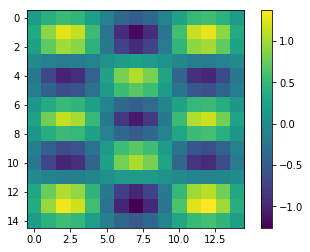

In [7]:
plt.imshow(GMM_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

Residual

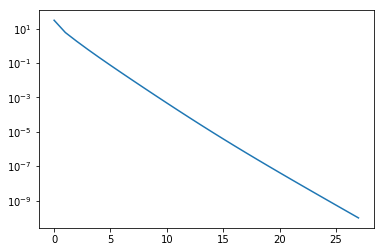

In [8]:
plt.semilogy(GMM_Res)

Radius

In [9]:
GMM_Radius = rho(inputsize,A1.to_full(),4*np.transpose(R),R,w,s)
print('GMM_Radius = {}'.format(GMM_Radius))

GMM_Radius = 0.4439325326515799


Global DMM optimization

In [10]:
Rnew, wnew, Rhoold, Rhonew, Radius = homotopy_optimizer_GD(inputsize, A0, A1.to_full(), R,  2/3, s, 
                                                           learning_rate = 1e-4,accept_radius =
                                                           GMM_Radius*10,step_length = 1e-2, lam = np.zeros([1,outputsize]))

======Section 1======
L = 0.02
rho = 0.44180616975522946
L = 0.03
rho = 0.44177528621512646
L = 0.04
rho = 0.4417465870015961
L = 0.05
rho = 0.4417196783958921
L = 0.060000000000000005
rho = 0.4416942259302667
L = 0.07
rho = 0.441669944468884
L = 0.08
rho = 0.44164659020503466
L = 0.09
rho = 0.44162395415468697
L = 0.09999999999999999
rho = 0.4416018568283916
L = 0.10999999999999999
rho = 0.441580143838597
L = 0.11999999999999998
rho = 0.4415586822551604
L = 0.12999999999999998
rho = 0.4415373575636162
L = 0.13999999999999999
rho = 0.4415160711123472
L = 0.15
rho = 0.44149473795887223
L = 0.16
rho = 0.44147328504395367
L = 0.17
rho = 0.4414516496365323
L = 0.18000000000000002
rho = 0.44142977800364247
L = 0.19000000000000003
rho = 0.44140762426820435
L = 0.20000000000000004
rho = 0.44138514942448936
L = 0.21000000000000005
rho = 0.4413623204865396
L = 0.22000000000000006
rho = 0.4413391097491979
L = 0.23000000000000007
rho = 0.4413154941449293
L = 0.24000000000000007
rho = 0.4412914546

the 26 steps
rho = 0.43700090704990274
the 27 steps
rho = 0.43694896302748193
the 28 steps
rho = 0.4368970840634905
the 29 steps
rho = 0.4368452690080818
the 30 steps
rho = 0.4367935167373897
the 31 steps
rho = 0.43674182615287066
the 32 steps
rho = 0.43669019618066324
the 33 steps
rho = 0.43663862577096735
the 34 steps
rho = 0.4365871138974407
the 35 steps
rho = 0.4365356595566129
the 36 steps
rho = 0.4364842617673156
the 37 steps
rho = 0.43643291957012936
the 38 steps
rho = 0.4363816320268458
the 39 steps
rho = 0.43633039821994485
the 40 steps
rho = 0.4362792172520865
the 41 steps
rho = 0.436228088245617
the 42 steps
rho = 0.4361770103420884
the 43 steps
rho = 0.43612598270179165
the 44 steps
rho = 0.43607500450330205
the 45 steps
rho = 0.43602407494303763
the 46 steps
rho = 0.43597319323482936
the 47 steps
rho = 0.43592235860950257
the 48 steps
rho = 0.4358715703144708
the 49 steps
rho = 0.43582082761333907
the 50 steps
rho = 0.4357701297855193
the 51 steps
rho = 0.4357194761258545


the 167 steps
rho = 0.43003174283362494
the 168 steps
rho = 0.4299837762911208
the 169 steps
rho = 0.42993582265476843
the 170 steps
rho = 0.4298878818520339
the 171 steps
rho = 0.42983995381156587
the 172 steps
rho = 0.4297920384631721
the 173 steps
rho = 0.4297441357377971
the 174 steps
rho = 0.42969624556749975
the 175 steps
rho = 0.4296483678854318
the 176 steps
rho = 0.42960050262581667
the 177 steps
rho = 0.4295526497239283
the 178 steps
rho = 0.42950480911607114
the 179 steps
rho = 0.42945698073956007
the 180 steps
rho = 0.4294091645327008
the 181 steps
rho = 0.4293613604347705
the 182 steps
rho = 0.4293135683859997
the 183 steps
rho = 0.42926578832755313
the 184 steps
rho = 0.42921802020151223
the 185 steps
rho = 0.4291702639508573
the 186 steps
rho = 0.42912251951945035
the 187 steps
rho = 0.4290747868520182
the 188 steps
rho = 0.4290270658941356
the 189 steps
rho = 0.4289793565922096
the 190 steps
rho = 0.42893165889346285
the 191 steps
rho = 0.42888397274591866
the 192 steps

the 307 steps
rho = 0.4234211773006073
the 308 steps
rho = 0.42337461928156883
the 309 steps
rho = 0.423328069694205
the 310 steps
rho = 0.42328152852497325
the 311 steps
rho = 0.42323499576043266
the 312 steps
rho = 0.4231884713872417
the 313 steps
rho = 0.42314195539215754
the 314 steps
rho = 0.4230954477620341
the 315 steps
rho = 0.4230489484838213
the 316 steps
rho = 0.4230024575445626
the 317 steps
rho = 0.42295597493139514
the 318 steps
rho = 0.4229095006315474
the 319 steps
rho = 0.422863034632338
the 320 steps
rho = 0.42281657692117475
the 321 steps
rho = 0.42277012748555354
the 322 steps
rho = 0.42272368631305673
the 323 steps
rho = 0.4226772533913522
the 324 steps
rho = 0.42263082870819185
the 325 steps
rho = 0.4225844122514111
the 326 steps
rho = 0.4225380040089272
the 327 steps
rho = 0.42249160396873825
the 328 steps
rho = 0.4224452121189223
the 329 steps
rho = 0.42239882844763604
the 330 steps
rho = 0.42235245294311397
the 331 steps
rho = 0.4223060855936672
the 332 steps
r

the 447 steps
rho = 0.41698015889001583
the 448 steps
rho = 0.4169346801440283
the 449 steps
rho = 0.4168892085278746
the 450 steps
rho = 0.41684374403488467
the 451 steps
rho = 0.41679828665841206
the 452 steps
rho = 0.4167528363918336
the 453 steps
rho = 0.4167073932285496
the 454 steps
rho = 0.4166619571619836
the 455 steps
rho = 0.41661652818558187
the 456 steps
rho = 0.41657110629281385
the 457 steps
rho = 0.41652569147717167
the 458 steps
rho = 0.4164802837321696
the 459 steps
rho = 0.41643488305134485
the 460 steps
rho = 0.41638948942825665
the 461 steps
rho = 0.4163441028564862
the 462 steps
rho = 0.41629872332963697
the 463 steps
rho = 0.4162533508413342
the 464 steps
rho = 0.4162079853852247
the 465 steps
rho = 0.4161626269549769
the 466 steps
rho = 0.41611727554428063
the 467 steps
rho = 0.4160719311468472
the 468 steps
rho = 0.4160265937564089
the 469 steps
rho = 0.4159812633667188
the 470 steps
rho = 0.41593593997155154
the 471 steps
rho = 0.41589062356470197
the 472 steps

the 587 steps
rho = 0.41067983177404876
the 588 steps
rho = 0.41063529501984314
the 589 steps
rho = 0.4105907646404412
the 590 steps
rho = 0.4105462406314721
the 591 steps
rho = 0.41050172298857723
the 592 steps
rho = 0.41045721170740895
the 593 steps
rho = 0.41041270678363145
the 594 steps
rho = 0.4103682082129203
the 595 steps
rho = 0.41032371599096246
the 596 steps
rho = 0.4102792301134563
the 597 steps
rho = 0.4102347505761115
the 598 steps
rho = 0.4101902773746489
the 599 steps
rho = 0.4101458105048009
the 600 steps
rho = 0.4101013499623106
the 601 steps
rho = 0.4100568957429328
the 602 steps
rho = 0.41001244784243285
the 603 steps
rho = 0.4099680062565875
the 604 steps
rho = 0.40992357098118465
the 605 steps
rho = 0.4098791420120227
the 606 steps
rho = 0.40983471934491134
the 607 steps
rho = 0.40979030297567104
the 608 steps
rho = 0.409745892900133
the 609 steps
rho = 0.4097014891141396
the 610 steps
rho = 0.4096570916135434
the 611 steps
rho = 0.4096127003942083
the 612 steps
rh

the 727 steps
rho = 0.4045049174907185
the 728 steps
rho = 0.40446123525859906
the 729 steps
rho = 0.40441755888488207
the 730 steps
rho = 0.4043738883664635
the 731 steps
rho = 0.40433022370024657
the 732 steps
rho = 0.4042865648831413
the 733 steps
rho = 0.4042429119120651
the 734 steps
rho = 0.4041992647839417
the 735 steps
rho = 0.4041556234957023
the 736 steps
rho = 0.4041119880442846
the 737 steps
rho = 0.40406835842663325
the 738 steps
rho = 0.40402473463969996
the 739 steps
rho = 0.4039811166804429
the 740 steps
rho = 0.40393750454582733
the 741 steps
rho = 0.4038938982328251
the 742 steps
rho = 0.40385029773841497
the 743 steps
rho = 0.4038067030595823
the 744 steps
rho = 0.40376311419331906
the 745 steps
rho = 0.40371953113662423
the 746 steps
rho = 0.40367595388650324
the 747 steps
rho = 0.403632382439968
the 748 steps
rho = 0.4035888167940374
the 749 steps
rho = 0.4035452569457366
the 750 steps
rho = 0.4035017028920976
the 751 steps
rho = 0.4034581546301588
the 752 steps
rh

the 867 steps
rho = 0.39844511653203235
the 868 steps
rho = 0.3984022270908972
the 869 steps
rho = 0.39835934313269616
the 870 steps
rho = 0.39831646465511733
the 871 steps
rho = 0.3982735916558535
the 872 steps
rho = 0.3982307241326018
the 873 steps
rho = 0.3981878620830638
the 874 steps
rho = 0.3981450055049457
the 875 steps
rho = 0.3981021543959581
the 876 steps
rho = 0.398059308753816
the 877 steps
rho = 0.39801646857623896
the 878 steps
rho = 0.397973633860951
the 879 steps
rho = 0.39793080460568037
the 880 steps
rho = 0.39788798080815996
the 881 steps
rho = 0.3978451624661268
the 882 steps
rho = 0.3978023495773223
the 883 steps
rho = 0.3977595421394927
the 884 steps
rho = 0.39771674015038805
the 885 steps
rho = 0.39767394360776287
the 886 steps
rho = 0.3976311525093763
the 887 steps
rho = 0.39758836685299137
the 888 steps
rho = 0.3975455866363757
the 889 steps
rho = 0.39750281185730113
the 890 steps
rho = 0.3974600425135437
the 891 steps
rho = 0.39741727860288384
the 892 steps
rh

the 1006 steps
rho = 0.3925351208526307
the 1007 steps
rho = 0.3924929731662496
the 1008 steps
rho = 0.3924508306796335
the 1009 steps
rho = 0.39240869339098977
the 1010 steps
rho = 0.3923665612985287
the 1011 steps
rho = 0.3923244344004638
the 1012 steps
rho = 0.3922823126950114
the 1013 steps
rho = 0.39224019618039097
the 1014 steps
rho = 0.392198084854825
the 1015 steps
rho = 0.392155978716539
the 1016 steps
rho = 0.3921138777637615
the 1017 steps
rho = 0.3920717819947239
the 1018 steps
rho = 0.3920296914076608
the 1019 steps
rho = 0.3919876060008096
the 1020 steps
rho = 0.3919455257724108
the 1021 steps
rho = 0.3919034507207076
the 1022 steps
rho = 0.3918613808439466
the 1023 steps
rho = 0.3918193161403769
the 1024 steps
rho = 0.39177725660825086
the 1025 steps
rho = 0.3917352022458237
the 1026 steps
rho = 0.3916931530513534
the 1027 steps
rho = 0.391651109023101
the 1028 steps
rho = 0.3916090701593306
the 1029 steps
rho = 0.39156703645830876
the 1030 steps
rho = 0.3915250079183054

the 1142 steps
rho = 0.3868500731211122
the 1143 steps
rho = 0.38680861729404964
the 1144 steps
rho = 0.3867671664479185
the 1145 steps
rho = 0.3867257205812752
the 1146 steps
rho = 0.3866842796926781
the 1147 steps
rho = 0.3866428437806883
the 1148 steps
rho = 0.3866014128438683
the 1149 steps
rho = 0.386559986880783
the 1150 steps
rho = 0.3865185658899999
the 1151 steps
rho = 0.3864771498700877
the 1152 steps
rho = 0.3864357388196179
the 1153 steps
rho = 0.38639433273716384
the 1154 steps
rho = 0.3863529316213011
the 1155 steps
rho = 0.38631153547060704
the 1156 steps
rho = 0.38627014428366147
the 1157 steps
rho = 0.3862287580590461
the 1158 steps
rho = 0.3861873767953448
the 1159 steps
rho = 0.38614600049114334
the 1160 steps
rho = 0.38610462914502974
the 1161 steps
rho = 0.386063262755594
the 1162 steps
rho = 0.38602190132142805
the 1163 steps
rho = 0.38598054484112604
the 1164 steps
rho = 0.3859391933132843
the 1165 steps
rho = 0.38589784673650085
the 1166 steps
rho = 0.3858565051

the 1280 steps
rho = 0.38117566406668185
the 1281 steps
rho = 0.3811348828059107
the 1282 steps
rho = 0.38109410634496443
the 1283 steps
rho = 0.3810533346826496
the 1284 steps
rho = 0.38101256781777443
the 1285 steps
rho = 0.38097180574914824
the 1286 steps
rho = 0.3809310484755821
the 1287 steps
rho = 0.3808902959958887
the 1288 steps
rho = 0.380849548308882
the 1289 steps
rho = 0.3808088054133778
the 1290 steps
rho = 0.3807680673081929
the 1291 steps
rho = 0.3807273339921461
the 1292 steps
rho = 0.38068660546405725
the 1293 steps
rho = 0.38064588172274816
the 1294 steps
rho = 0.3806051627670418
the 1295 steps
rho = 0.3805644485957627
the 1296 steps
rho = 0.38052373920773697
the 1297 steps
rho = 0.38048303460179195
the 1298 steps
rho = 0.3804423347767567
the 1299 steps
rho = 0.3804016397314616
the 1300 steps
rho = 0.38036094946473864
the 1301 steps
rho = 0.38032026397542107
the 1302 steps
rho = 0.38027958326234373
the 1303 steps
rho = 0.38023890732434307
the 1304 steps
rho = 0.380198

the 1416 steps
rho = 0.37567300514384994
the 1417 steps
rho = 0.3756328662813803
the 1418 steps
rho = 0.3755927320690447
the 1419 steps
rho = 0.3755526025058277
the 1420 steps
rho = 0.3755124775907149
the 1421 steps
rho = 0.37547235732269263
the 1422 steps
rho = 0.37543224170074885
the 1423 steps
rho = 0.37539213072387245
the 1424 steps
rho = 0.3753520243910534
the 1425 steps
rho = 0.37531192270128266
the 1426 steps
rho = 0.37527182565355255
the 1427 steps
rho = 0.3752317332468565
the 1428 steps
rho = 0.37519164548018885
the 1429 steps
rho = 0.3751515623525451
the 1430 steps
rho = 0.375111483862922
the 1431 steps
rho = 0.3750714100103172
the 1432 steps
rho = 0.3750313407937297
the 1433 steps
rho = 0.3749912762121594
the 1434 steps
rho = 0.37495121626460726
the 1435 steps
rho = 0.3749111609500756
the 1436 steps
rho = 0.37487111026756764
the 1437 steps
rho = 0.37483106421608764
the 1438 steps
rho = 0.37479102279464105
the 1439 steps
rho = 0.37475098600223455
the 1440 steps
rho = 0.374710

the 1553 steps
rho = 0.3702168913397986
the 1554 steps
rho = 0.37017738055004185
the 1555 steps
rho = 0.3701378742819764
the 1556 steps
rho = 0.3700983725347669
the 1557 steps
rho = 0.3700588753075805
the 1558 steps
rho = 0.3700193825995871
the 1559 steps
rho = 0.3699798944099591
the 1560 steps
rho = 0.36994041073787176
the 1561 steps
rho = 0.3699009315825032
the 1562 steps
rho = 0.36986145694303457
the 1563 steps
rho = 0.3698219868186498
the 1564 steps
rho = 0.36978252120853594
the 1565 steps
rho = 0.3697430601118834
the 1566 steps
rho = 0.3697036035278854
the 1567 steps
rho = 0.36966415145573867
the 1568 steps
rho = 0.3696247038946434
the 1569 steps
rho = 0.3695852608438031
the 1570 steps
rho = 0.3695458223024251
the 1571 steps
rho = 0.36950638826972027
the 1572 steps
rho = 0.36946695874490293
the 1573 steps
rho = 0.36942753372719184
the 1574 steps
rho = 0.3693881132158095
the 1575 steps
rho = 0.36934869720998226
the 1576 steps
rho = 0.3693092857089412
the 1577 steps
rho = 0.36926987

the 1689 steps
rho = 0.3648846891504731
the 1690 steps
rho = 0.364845789801852
the 1691 steps
rho = 0.3648068950204903
the 1692 steps
rho = 0.36476800481126265
the 1693 steps
rho = 0.3647291191792435
the 1694 steps
rho = 0.36469023812971335
the 1695 steps
rho = 0.36465136166816636
the 1696 steps
rho = 0.36461248980031785
the 1697 steps
rho = 0.3645736225321119
the 1698 steps
rho = 0.36453475986972883
the 1699 steps
rho = 0.36449590181959424
the 1700 steps
rho = 0.36445704838838705
the 1701 steps
rho = 0.36441819958304805
the 1702 steps
rho = 0.36437935541078975
the 1703 steps
rho = 0.3643405158791051
the 1704 steps
rho = 0.36430168099577775
the 1705 steps
rho = 0.3642628507688916
the 1706 steps
rho = 0.3642240252068417
the 1707 steps
rho = 0.364185204318345
the 1708 steps
rho = 0.3641463881124512
the 1709 steps
rho = 0.36410757659855475
the 1710 steps
rho = 0.3640687697864064
the 1711 steps
rho = 0.36402996768612556
the 1712 steps
rho = 0.36399117030821365
the 1713 steps
rho = 0.363952

the 1825 steps
rho = 0.3596477797096073
the 1826 steps
rho = 0.3596099526215947
the 1827 steps
rho = 0.35957214640210255
the 1828 steps
rho = 0.35953436160657964
the 1829 steps
rho = 0.3594965988085678
the 1830 steps
rho = 0.3594588586002556
the 1831 steps
rho = 0.35942114159304484
the 1832 steps
rho = 0.35938344841813286
the 1833 steps
rho = 0.3593457797271098
the 1834 steps
rho = 0.3593081361925701
the 1835 steps
rho = 0.35927051850874075
the 1836 steps
rho = 0.35923292739212376
the 1837 steps
rho = 0.35919536358215526
the 1838 steps
rho = 0.3591578278418799
the 1839 steps
rho = 0.3591203209586413
the 1840 steps
rho = 0.35908284374478905
the 1841 steps
rho = 0.35904539703840116
the 1842 steps
rho = 0.35900798170402276
the 1843 steps
rho = 0.3589705986334218
the 1844 steps
rho = 0.3589332487463602
the 1845 steps
rho = 0.3588959329913813
the 1846 steps
rho = 0.35885865234661385
the 1847 steps
rho = 0.35882140782059174
the 1848 steps
rho = 0.3587842004530897
the 1849 steps
rho = 0.35874

the 1963 steps
rho = 0.355375355021189
the 1964 steps
rho = 0.3553606759683009
the 1965 steps
rho = 0.35534633717537867
the 1966 steps
rho = 0.35533233640818984
the 1967 steps
rho = 0.3553186712211162
the 1968 steps
rho = 0.35530533896177957
the 1969 steps
rho = 0.3552923367761661
the 1970 steps
rho = 0.3552796616142287
the 1971 steps
rho = 0.3552673102359443
the 1972 steps
rho = 0.35525527921779887
the 1973 steps
rho = 0.3552435649596732
the 1974 steps
rho = 0.3552321636920999
the 1975 steps
rho = 0.35522107148386023
the 1976 steps
rho = 0.35521028424988815
the 1977 steps
rho = 0.35519979775944843
the 1978 steps
rho = 0.35518960764455443
the 1979 steps
rho = 0.35517970940859
the 1980 steps
rho = 0.3551700984351014
the 1981 steps
rho = 0.35516076999672164
the 1982 steps
rho = 0.35515171926419503
the 1983 steps
rho = 0.3551429413154638
the 1984 steps
rho = 0.3551344311447846
the 1985 steps
rho = 0.35512618367184
the 1986 steps
rho = 0.3551181937508133
the 1987 steps
rho = 0.355110456179

the 2100 steps
rho = 0.354910353844825
the 2101 steps
rho = 0.3549102181283887
the 2102 steps
rho = 0.35491008454776696
the 2103 steps
rho = 0.35490995299794326
the 2104 steps
rho = 0.35490982337905563
the 2105 steps
rho = 0.3549096955961513
the 2106 steps
rho = 0.3549095695589514
the 2107 steps
rho = 0.35490944518162676
the 2108 steps
rho = 0.3549093223825843
the 2109 steps
rho = 0.3549092010842628
the 2110 steps
rho = 0.35490908121293846
the 2111 steps
rho = 0.35490896269853905
the 2112 steps
rho = 0.35490884547446716
the 2113 steps
rho = 0.3549087294774316
the 2114 steps
rho = 0.3549086146472861
the 2115 steps
rho = 0.3549085009268768
the 2116 steps
rho = 0.3549083882618954
the 2117 steps
rho = 0.35490827660074076
the 2118 steps
rho = 0.3549081658943857
the 2119 steps
rho = 0.35490805609625115
the 2120 steps
rho = 0.3549079471620856
the 2121 steps
rho = 0.3549078390498509
the 2122 steps
rho = 0.35490773171961293
the 2123 steps
rho = 0.3549076251334379
the 2124 steps
rho = 0.35490751

the 2236 steps
rho = 0.35489703379871246
the 2237 steps
rho = 0.35489694382774845
the 2238 steps
rho = 0.3548968538835586
the 2239 steps
rho = 0.3548967639659668
the 2240 steps
rho = 0.35489667407480135
the 2241 steps
rho = 0.35489658420989495
the 2242 steps
rho = 0.35489649437108456
the 2243 steps
rho = 0.3548964045582109
the 2244 steps
rho = 0.3548963147711186
the 2245 steps
rho = 0.3548962250096559
the 2246 steps
rho = 0.3548961352736742
the 2247 steps
rho = 0.35489604556302856
the 2248 steps
rho = 0.3548959558775767
the 2249 steps
rho = 0.35489586621717956
the 2250 steps
rho = 0.35489577658170074
the 2251 steps
rho = 0.35489568697100665
the 2252 steps
rho = 0.3548955973849661
the 2253 steps
rho = 0.3548955078234505
the 2254 steps
rho = 0.35489541828633336
the 2255 steps
rho = 0.35489532877349056
the 2256 steps
rho = 0.35489523928479993
the 2257 steps
rho = 0.3548951498201416
the 2258 steps
rho = 0.3548950603793973
the 2259 steps
rho = 0.3548949709624507
the 2260 steps
rho = 0.35489

the 2374 steps
rho = 0.3548848231722584
the 2375 steps
rho = 0.35488473593051645
the 2376 steps
rho = 0.3548846487032888
the 2377 steps
rho = 0.35488456149051084
the 2378 steps
rho = 0.35488447429211806
the 2379 steps
rho = 0.35488438710804626
the 2380 steps
rho = 0.35488429993823123
the 2381 steps
rho = 0.354884212782609
the 2382 steps
rho = 0.35488412564111577
the 2383 steps
rho = 0.35488403851368766
the 2384 steps
rho = 0.35488395140026124
the 2385 steps
rho = 0.35488386430077296
the 2386 steps
rho = 0.3548837772151595
the 2387 steps
rho = 0.3548836901433578
the 2388 steps
rho = 0.3548836030853047
the 2389 steps
rho = 0.3548835160409374
the 2390 steps
rho = 0.354883429010193
the 2391 steps
rho = 0.35488334199300897
the 2392 steps
rho = 0.35488325498932277
the 2393 steps
rho = 0.354883167999072
the 2394 steps
rho = 0.3548830810221945
the 2395 steps
rho = 0.3548829940586281
the 2396 steps
rho = 0.3548829071083109
the 2397 steps
rho = 0.3548828201711809
the 2398 steps
rho = 0.354882733

the 2511 steps
rho = 0.3548729809648852
the 2512 steps
rho = 0.3548728951612141
the 2513 steps
rho = 0.3548728093642946
the 2514 steps
rho = 0.3548727235740767
the 2515 steps
rho = 0.3548726377905103
the 2516 steps
rho = 0.3548725520135457
the 2517 steps
rho = 0.35487246624313296
the 2518 steps
rho = 0.35487238047922226
the 2519 steps
rho = 0.35487229472176435
the 2520 steps
rho = 0.3548722089707093
the 2521 steps
rho = 0.3548721232260078
the 2522 steps
rho = 0.3548720374876105
the 2523 steps
rho = 0.35487195175546793
the 2524 steps
rho = 0.3548718660295309
the 2525 steps
rho = 0.35487178030975036
the 2526 steps
rho = 0.35487169459607715
the 2527 steps
rho = 0.35487160888846225
the 2528 steps
rho = 0.3548715231868568
the 2529 steps
rho = 0.35487143749121175
the 2530 steps
rho = 0.35487135180147855
the 2531 steps
rho = 0.35487126611760844
the 2532 steps
rho = 0.35487118043955296
the 2533 steps
rho = 0.3548710947672632
the 2534 steps
rho = 0.35487100910069097
the 2535 steps
rho = 0.35487

the 2649 steps
rho = 0.35486118353529617
the 2650 steps
rho = 0.3548610982224138
the 2651 steps
rho = 0.354861012910071
the 2652 steps
rho = 0.35486092759822757
the 2653 steps
rho = 0.35486084228684317
the 2654 steps
rho = 0.35486075697587793
the 2655 steps
rho = 0.35486067166529156
the 2656 steps
rho = 0.3548605863550441
the 2657 steps
rho = 0.3548605010450956
the 2658 steps
rho = 0.3548604157354062
the 2659 steps
rho = 0.3548603304259361
the 2660 steps
rho = 0.3548602451166456
the 2661 steps
rho = 0.354860159807495
the 2662 steps
rho = 0.3548600744984446
the 2663 steps
rho = 0.35485998918945494
the 2664 steps
rho = 0.3548599038804865
the 2665 steps
rho = 0.3548598185714999
the 2666 steps
rho = 0.35485973326245573
the 2667 steps
rho = 0.35485964795331476
the 2668 steps
rho = 0.3548595626440378
the 2669 steps
rho = 0.3548594773345856
the 2670 steps
rho = 0.3548593920249192
the 2671 steps
rho = 0.3548593067149993
the 2672 steps
rho = 0.35485922140478726
the 2673 steps
rho = 0.3548591360

the 2788 steps
rho = 0.3548493135625307
the 2789 steps
rho = 0.3548492279673433
the 2790 steps
rho = 0.3548491423677354
the 2791 steps
rho = 0.35484905676367623
the 2792 steps
rho = 0.354848971155135
the 2793 steps
rho = 0.3548488855420808
the 2794 steps
rho = 0.35484879992448326
the 2795 steps
rho = 0.35484871430231163
the 2796 steps
rho = 0.35484862867553535
the 2797 steps
rho = 0.3548485430441242
the 2798 steps
rho = 0.3548484574080477
the 2799 steps
rho = 0.35484837176727557
the 2800 steps
rho = 0.3548482861217776
the 2801 steps
rho = 0.35484820047152377
the 2802 steps
rho = 0.35484811481648376
the 2803 steps
rho = 0.3548480291566278
the 2804 steps
rho = 0.35484794349192594
the 2805 steps
rho = 0.35484785782234834
the 2806 steps
rho = 0.3548477721478651
the 2807 steps
rho = 0.3548476864684467
the 2808 steps
rho = 0.3548476007840636
the 2809 steps
rho = 0.354847515094686
the 2810 steps
rho = 0.3548474294002846
the 2811 steps
rho = 0.35484734370082993
the 2812 steps
rho = 0.354847257

the 2924 steps
rho = 0.35483762041668687
the 2925 steps
rho = 0.3548375339685119
the 2926 steps
rho = 0.35483744751244034
the 2927 steps
rho = 0.3548373610484525
the 2928 steps
rho = 0.3548372745765287
the 2929 steps
rho = 0.3548371880966495
the 2930 steps
rho = 0.3548371016087955
the 2931 steps
rho = 0.35483701511294735
the 2932 steps
rho = 0.35483692860908583
the 2933 steps
rho = 0.3548368420971918
the 2934 steps
rho = 0.35483675557724637
the 2935 steps
rho = 0.3548366690492304
the 2936 steps
rho = 0.35483658251312516
the 2937 steps
rho = 0.3548364959689119
the 2938 steps
rho = 0.35483640941657196
the 2939 steps
rho = 0.35483632285608685
the 2940 steps
rho = 0.354836236287438
the 2941 steps
rho = 0.3548361497106071
the 2942 steps
rho = 0.354836063125576
the 2943 steps
rho = 0.35483597653232635
the 2944 steps
rho = 0.3548358899308402
the 2945 steps
rho = 0.3548358033210995
the 2946 steps
rho = 0.35483571670308645
the 2947 steps
rho = 0.35483563007678326
the 2948 steps
rho = 0.35483554

the 3060 steps
rho = 0.35482578425599937
the 3061 steps
rho = 0.3548256965945377
the 3062 steps
rho = 0.35482560892345266
the 3063 steps
rho = 0.35482552124273953
the 3064 steps
rho = 0.3548254335523933
the 3065 steps
rho = 0.3548253458524096
the 3066 steps
rho = 0.3548252581427838
the 3067 steps
rho = 0.35482517042351164
the 3068 steps
rho = 0.35482508269458884
the 3069 steps
rho = 0.3548249949560113
the 3070 steps
rho = 0.354824907207775
the 3071 steps
rho = 0.35482481944987615
the 3072 steps
rho = 0.35482473168231105
the 3073 steps
rho = 0.35482464390507595
the 3074 steps
rho = 0.35482455611816766
the 3075 steps
rho = 0.3548244683215826
the 3076 steps
rho = 0.35482438051531756
the 3077 steps
rho = 0.35482429269936966
the 3078 steps
rho = 0.3548242048737359
the 3079 steps
rho = 0.35482411703841327
the 3080 steps
rho = 0.3548240291933993
the 3081 steps
rho = 0.35482394133869133
the 3082 steps
rho = 0.354823853474287
the 3083 steps
rho = 0.354823765600184
the 3084 steps
rho = 0.3548236

the 3198 steps
rho = 0.35481359584980576
the 3199 steps
rho = 0.3548135068723647
the 3200 steps
rho = 0.3548134178859406
the 3201 steps
rho = 0.3548133288905488
the 3202 steps
rho = 0.3548132398862045
the 3203 steps
rho = 0.35481315087292337
the 3204 steps
rho = 0.35481306185072115
the 3205 steps
rho = 0.35481297281961366
the 3206 steps
rho = 0.35481288377961695
the 3207 steps
rho = 0.35481279473074734
the 3208 steps
rho = 0.35481270567302114
the 3209 steps
rho = 0.3548126166064549
the 3210 steps
rho = 0.3548125275310654
the 3211 steps
rho = 0.3548124384468695
the 3212 steps
rho = 0.3548123493538842
the 3213 steps
rho = 0.3548122602521269
the 3214 steps
rho = 0.3548121711416149
the 3215 steps
rho = 0.35481208202236575
the 3216 steps
rho = 0.35481199289439724
the 3217 steps
rho = 0.3548119037577273
the 3218 steps
rho = 0.35481181461237404
the 3219 steps
rho = 0.35481172545835565
the 3220 steps
rho = 0.3548116362956906
the 3221 steps
rho = 0.35481154712439744
the 3222 steps
rho = 0.35481

the 3335 steps
rho = 0.3548013310857275
the 3336 steps
rho = 0.3548012410934437
the 3337 steps
rho = 0.35480115109594024
the 3338 steps
rho = 0.3548010610932579
the 3339 steps
rho = 0.3548009710854378
the 3340 steps
rho = 0.35480088107252117
the 3341 steps
rho = 0.3548007910545496
the 3342 steps
rho = 0.3548007010315646
the 3343 steps
rho = 0.3548006110036082
the 3344 steps
rho = 0.35480052097072245
the 3345 steps
rho = 0.3548004309329497
the 3346 steps
rho = 0.35480034089033247
the 3347 steps
rho = 0.3548002508429136
the 3348 steps
rho = 0.35480016079073584
the 3349 steps
rho = 0.3548000707338424
the 3350 steps
rho = 0.3547999806722768
the 3351 steps
rho = 0.35479989060608247
the 3352 steps
rho = 0.3547998005353032
the 3353 steps
rho = 0.3547997104599831
the 3354 steps
rho = 0.35479962038016627
the 3355 steps
rho = 0.3547995302958973
the 3356 steps
rho = 0.3547994402072206
the 3357 steps
rho = 0.3547993501141812
the 3358 steps
rho = 0.35479926001682405
the 3359 steps
rho = 0.354799169

the 3474 steps
rho = 0.3547887931940868
the 3475 steps
rho = 0.3547887029631093
the 3476 steps
rho = 0.3547886127346988
the 3477 steps
rho = 0.3547885225089274
the 3478 steps
rho = 0.3547884322858675
the 3479 steps
rho = 0.3547883420655917
the 3480 steps
rho = 0.3547882518481728
the 3481 steps
rho = 0.35478816163368415
the 3482 steps
rho = 0.3547880714221989
the 3483 steps
rho = 0.3547879812137908
the 3484 steps
rho = 0.3547878910085336
the 3485 steps
rho = 0.35478780080650135
the 3486 steps
rho = 0.3547877106077685
the 3487 steps
rho = 0.35478762041240947
the 3488 steps
rho = 0.35478753022049914
the 3489 steps
rho = 0.3547874400321126
the 3490 steps
rho = 0.354787349847325
the 3491 steps
rho = 0.354787259666212
the 3492 steps
rho = 0.3547871694888493
the 3493 steps
rho = 0.354787079315313
the 3494 steps
rho = 0.3547869891456792
the 3495 steps
rho = 0.3547868989800246
the 3496 steps
rho = 0.3547868088184257
the 3497 steps
rho = 0.35478671866095973
the 3498 steps
rho = 0.354786628507703

the 3614 steps
rho = 0.35477622185738866
the 3615 steps
rho = 0.35477613279696724
the 3616 steps
rho = 0.35477604375159355
the 3617 steps
rho = 0.3547759547213742
the 3618 steps
rho = 0.3547758657064161
the 3619 steps
rho = 0.3547757767068259
the 3620 steps
rho = 0.3547756877227112
the 3621 steps
rho = 0.3547755987541793
the 3622 steps
rho = 0.3547755098013379
the 3623 steps
rho = 0.35477542086429503
the 3624 steps
rho = 0.35477533194315886
the 3625 steps
rho = 0.3547752430380379
the 3626 steps
rho = 0.3547751541490408
the 3627 steps
rho = 0.35477506527627656
the 3628 steps
rho = 0.35477497641985434
the 3629 steps
rho = 0.3547748875798836
the 3630 steps
rho = 0.3547747987564739
the 3631 steps
rho = 0.3547747099497353
the 3632 steps
rho = 0.3547746211597778
the 3633 steps
rho = 0.35477453238671197
the 3634 steps
rho = 0.35477444363064836
the 3635 steps
rho = 0.35477435489169784
the 3636 steps
rho = 0.3547742661699716
the 3637 steps
rho = 0.35477417746558093
the 3638 steps
rho = 0.354774

the 3750 steps
rho = 0.3547642947193906
the 3751 steps
rho = 0.3547642087808302
the 3752 steps
rho = 0.3547641228739604
the 3753 steps
rho = 0.3547640369989188
the 3754 steps
rho = 0.35476395115584297
the 3755 steps
rho = 0.35476386534487087
the 3756 steps
rho = 0.35476377956614075
the 3757 steps
rho = 0.3547636938197908
the 3758 steps
rho = 0.3547636081059596
the 3759 steps
rho = 0.3547635224247858
the 3760 steps
rho = 0.35476343677640854
the 3761 steps
rho = 0.35476335116096663
the 3762 steps
rho = 0.35476326557859966
the 3763 steps
rho = 0.3547631800294471
the 3764 steps
rho = 0.35476309451364857
the 3765 steps
rho = 0.354763009031344
the 3766 steps
rho = 0.3547629235826736
the 3767 steps
rho = 0.3547628381677776
the 3768 steps
rho = 0.35476275278679653
the 3769 steps
rho = 0.354762667439871
the 3770 steps
rho = 0.35476258212714196
the 3771 steps
rho = 0.3547624968487505
the 3772 steps
rho = 0.3547624116048379
the 3773 steps
rho = 0.35476232639554556
the 3774 steps
rho = 0.354762241

the 3889 steps
rho = 0.354752716206399
the 3890 steps
rho = 0.3547526360711747
the 3891 steps
rho = 0.35475255598841515
the 3892 steps
rho = 0.35475247595827936
the 3893 steps
rho = 0.3547523959809265
the 3894 steps
rho = 0.35475231605651597
the 3895 steps
rho = 0.3547522361852071
the 3896 steps
rho = 0.3547521563671594
the 3897 steps
rho = 0.3547520766025324
the 3898 steps
rho = 0.3547519968914857
the 3899 steps
rho = 0.3547519172341792
the 3900 steps
rho = 0.35475183763077267
the 3901 steps
rho = 0.35475175808142595
the 3902 steps
rho = 0.35475167858629925
the 3903 steps
rho = 0.35475159914555254
the 3904 steps
rho = 0.35475151975934605
the 3905 steps
rho = 0.3547514404278401
the 3906 steps
rho = 0.35475136115119493
the 3907 steps
rho = 0.3547512819295711
the 3908 steps
rho = 0.3547512027631291
the 3909 steps
rho = 0.35475112365202954
the 3910 steps
rho = 0.35475104459643303
the 3911 steps
rho = 0.35475096559650043
the 3912 steps
rho = 0.35475088665239257
the 3913 steps
rho = 0.35475

the 4026 steps
rho = 0.3547422941009111
the 4027 steps
rho = 0.35474222266099326
the 4028 steps
rho = 0.3547421512957808
the 4029 steps
rho = 0.3547420800054356
the 4030 steps
rho = 0.35474200879011963
the 4031 steps
rho = 0.3547419376499946
the 4032 steps
rho = 0.3547418665852224
the 4033 steps
rho = 0.35474179559596464
the 4034 steps
rho = 0.35474172468238285
the 4035 steps
rho = 0.3547416538446388
the 4036 steps
rho = 0.3547415830828936
the 4037 steps
rho = 0.354741512397309
the 4038 steps
rho = 0.35474144178804623
the 4039 steps
rho = 0.3547413712552664
the 4040 steps
rho = 0.35474130079913074
the 4041 steps
rho = 0.3547412304198005
the 4042 steps
rho = 0.35474116011743645
the 4043 steps
rho = 0.3547410898921998
the 4044 steps
rho = 0.3547410197442512
the 4045 steps
rho = 0.3547409496737515
the 4046 steps
rho = 0.3547408796808614
the 4047 steps
rho = 0.3547408097657414
the 4048 steps
rho = 0.35474073992855226
the 4049 steps
rho = 0.35474067016945415
the 4050 steps
rho = 0.354740600

the 4163 steps
rho = 0.3547332693022585
the 4164 steps
rho = 0.3547332095608518
the 4165 steps
rho = 0.3547331499152033
the 4166 steps
rho = 0.3547330903654545
the 4167 steps
rho = 0.3547330309117463
the 4168 steps
rho = 0.35473297155421957
the 4169 steps
rho = 0.3547329122930148
the 4170 steps
rho = 0.35473285312827235
the 4171 steps
rho = 0.3547327940601322
the 4172 steps
rho = 0.3547327350887344
the 4173 steps
rho = 0.3547326762142183
the 4174 steps
rho = 0.3547326174367234
the 4175 steps
rho = 0.35473255875638865
the 4176 steps
rho = 0.35473250017335306
the 4177 steps
rho = 0.35473244168775514
the 4178 steps
rho = 0.3547323832997334
the 4179 steps
rho = 0.3547323250094257
the 4180 steps
rho = 0.35473226681697
the 4181 steps
rho = 0.35473220872250405
the 4182 steps
rho = 0.35473215072616504
the 4183 steps
rho = 0.3547320928280901
the 4184 steps
rho = 0.3547320350284161
the 4185 steps
rho = 0.3547319773272796
the 4186 steps
rho = 0.35473191972481694
the 4187 steps
rho = 0.35473186222

the 4302 steps
rho = 0.3547259416037678
the 4303 steps
rho = 0.3547258964091181
the 4304 steps
rho = 0.35472585132717016
the 4305 steps
rho = 0.35472580635802375
the 4306 steps
rho = 0.3547257615017781
the 4307 steps
rho = 0.3547257167585323
the 4308 steps
rho = 0.35472567212838507
the 4309 steps
rho = 0.3547256276114347
the 4310 steps
rho = 0.35472558320777925
the 4311 steps
rho = 0.35472553891751635
the 4312 steps
rho = 0.35472549474074333
the 4313 steps
rho = 0.3547254506775571
the 4314 steps
rho = 0.3547254067280544
the 4315 steps
rho = 0.3547253628923314
the 4316 steps
rho = 0.3547253191704841
the 4317 steps
rho = 0.35472527556260813
the 4318 steps
rho = 0.35472523206879863
the 4319 steps
rho = 0.3547251886891505
the 4320 steps
rho = 0.35472514542375844
the 4321 steps
rho = 0.3547251022727165
the 4322 steps
rho = 0.35472505923611863
the 4323 steps
rho = 0.35472501631405845
the 4324 steps
rho = 0.3547249735066289
the 4325 steps
rho = 0.3547249308139229
the 4326 steps
rho = 0.354724

the 4438 steps
rho = 0.35472086592956553
the 4439 steps
rho = 0.354720836837076
the 4440 steps
rho = 0.35472080786772603
the 4441 steps
rho = 0.35472077902157023
the 4442 steps
rho = 0.354720750298663
the 4443 steps
rho = 0.3547207216990585
the 4444 steps
rho = 0.3547206932228103
the 4445 steps
rho = 0.35472066486997217
the 4446 steps
rho = 0.35472063664059716
the 4447 steps
rho = 0.35472060853473825
the 4448 steps
rho = 0.3547205805524482
the 4449 steps
rho = 0.35472055269377917
the 4450 steps
rho = 0.3547205249587834
the 4451 steps
rho = 0.3547204973475129
the 4452 steps
rho = 0.3547204698600189
the 4453 steps
rho = 0.35472044249635293
the 4454 steps
rho = 0.3547204152565658
the 4455 steps
rho = 0.35472038814070833
the 4456 steps
rho = 0.354720361148831
the 4457 steps
rho = 0.354720334280984
the 4458 steps
rho = 0.35472030753721717
the 4459 steps
rho = 0.3547202809175803
the 4460 steps
rho = 0.3547202544221226
the 4461 steps
rho = 0.3547202280508935
the 4462 steps
rho = 0.35472020180

the 4574 steps
rho = 0.35471805875885676
the 4575 steps
rho = 0.3547180468167126
the 4576 steps
rho = 0.3547180350031214
the 4577 steps
rho = 0.3547180233181136
the 4578 steps
rho = 0.3547180117617198
the 4579 steps
rho = 0.35471800033397066
the 4580 steps
rho = 0.35471798903489654
the 4581 steps
rho = 0.35471797786452797
the 4582 steps
rho = 0.3547179668228955
the 4583 steps
rho = 0.35471795591002964
the 4584 steps
rho = 0.3547179451259606
the 4585 steps
rho = 0.35471793447071903
the 4586 steps
rho = 0.3547179239443352
the 4587 steps
rho = 0.3547179135468397
the 4588 steps
rho = 0.3547179032782627
the 4589 steps
rho = 0.3547178931386348
the 4590 steps
rho = 0.3547178831279863
the 4591 steps
rho = 0.35471787324634757
the 4592 steps
rho = 0.3547178634937492
the 4593 steps
rho = 0.35471785387022137
the 4594 steps
rho = 0.35471784437579484
the 4595 steps
rho = 0.35471783501049975
the 4596 steps
rho = 0.3547178257743668
the 4597 steps
rho = 0.3547178166674263
the 4598 steps
rho = 0.3547178

Global DMM on fine grid

In [11]:
DMM_U, DMM_Res = Multigrid_circle(inputsize, A1.to_full(), RightF, Rnew, s, wnew, error)

Residual = 28.136495443743563
Interation = 1
Residual = 4.078002841997266
Interation = 2
Residual = 0.923581971897882
Interation = 3
Residual = 0.2266901934418066
Interation = 4
Residual = 0.05856181933565202
Interation = 5
Residual = 0.015603395881670078
Interation = 6
Residual = 0.0042342099227321295
Interation = 7
Residual = 0.0011628733287016952
Interation = 8
Residual = 0.00032248342923162006
Interation = 9
Residual = 9.030565774083408e-05
Interation = 10
Residual = 2.5569853358871172e-05
Interation = 11
Residual = 7.33475421654673e-06
Interation = 12
Residual = 2.1358087048800094e-06
Interation = 13
Residual = 6.32360746906029e-07
Interation = 14
Residual = 1.9052900121430786e-07
Interation = 15
Residual = 5.8410461894533645e-08
Interation = 16
Residual = 1.8200519147660168e-08
Interation = 17
Residual = 5.7540477470758356e-09
Interation = 18
Residual = 1.8418257901909035e-09
Interation = 19
Residual = 5.956542007738248e-10
Interation = 20
Residual = 1.9426022829770314e-10
Intera

Error DMM on fine grid

In [12]:
UREAL = Ureal.reshape(sqrtinputsize,sqrtinputsize)
DMMU = DMM_U.reshape(sqrtinputsize,sqrtinputsize)
deltaU = DMMU - UREAL

energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=0),np.gradient(UREAL,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=1),np.gradient(UREAL,h,axis=1)),Media)*(h**2)))
l2norm = np.sqrt((np.linalg.norm(UREAL)**2)*(h**2))
h1norm = np.sqrt((np.linalg.norm(np.gradient(UREAL,h,axis=0))**2+np.linalg.norm(np.gradient(UREAL,h,axis=1))**2+np.linalg.norm(UREAL)**2)*(h**2))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2))))
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2)))
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2)))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2))/h1norm)

Energy norm: 
4.015482028274982
L2 norm: 
0.22283533003733022
H1 norm: 
2.174861344479955
Energy norm: 
0.26710328970393826
L2 norm: 
0.44567066007466044
H1 norm: 
0.2647605523790448


Solution

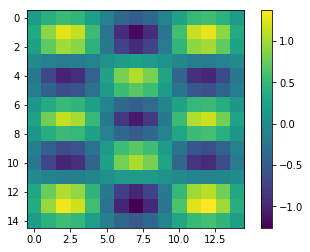

In [13]:
plt.imshow(DMM_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

Residual

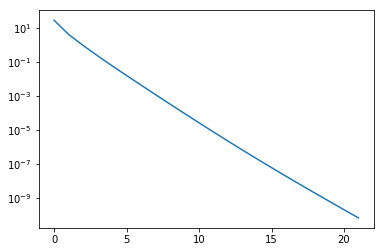

In [14]:
plt.semilogy(DMM_Res)

Radius

In [15]:
DMM_Radius = Rhonew
print('DMM_Radius = {}'.format(DMM_Radius))

DMM_Radius = 0.35471750211165387


In [16]:
wnew

array(0.80167031)

Rrestriction matrix after optimization

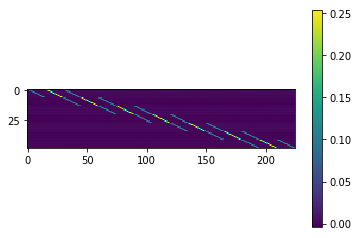

In [17]:
plt.imshow(Rnew)
plt.colorbar()

Rrestriction matrix (log(abs()) after optimization

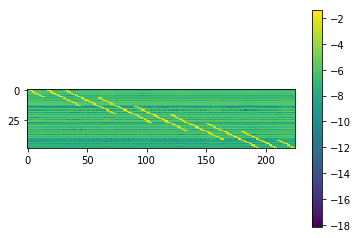

In [18]:
plt.imshow(np.log(np.abs(Rnew)))
plt.colorbar()

Basis after optimization

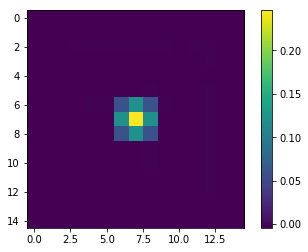

In [19]:
basis1 = Rnew[int(0.5*outputsize)][:]
basis1 = basis1.reshape([sqrtinputsize,sqrtinputsize])
plt.imshow(basis1)
plt.colorbar()

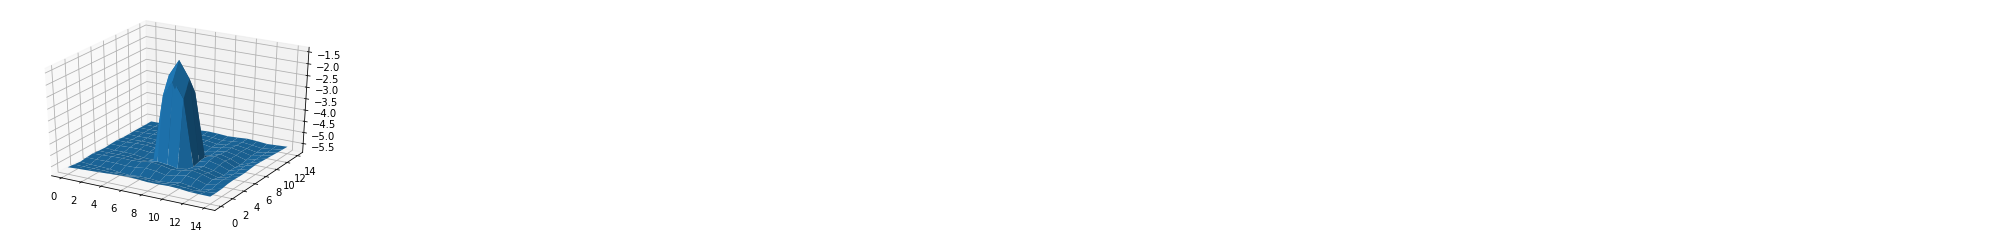

In [20]:
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
size=basis1.shape
Y=np.arange(0,size[0],1)     
X=np.arange(0,size[1],1)

X,Y=np.meshgrid(X,Y)    
fig=plt.figure()
ax=fig.gca(projection='3d') 
ax.plot_surface(X,Y,np.log(abs(basis1)))
plt.show()

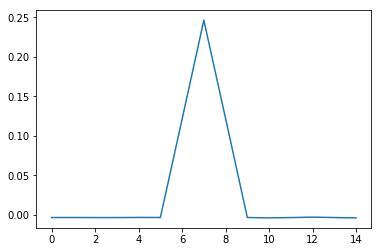

In [21]:
plt.plot(basis1[:][int(sqrtinputsize/2)])

Basis after optimization (log(abs()))

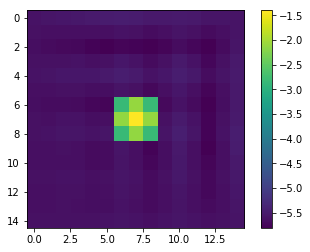

In [22]:
plt.imshow(np.log(np.abs(basis1)))
plt.colorbar()

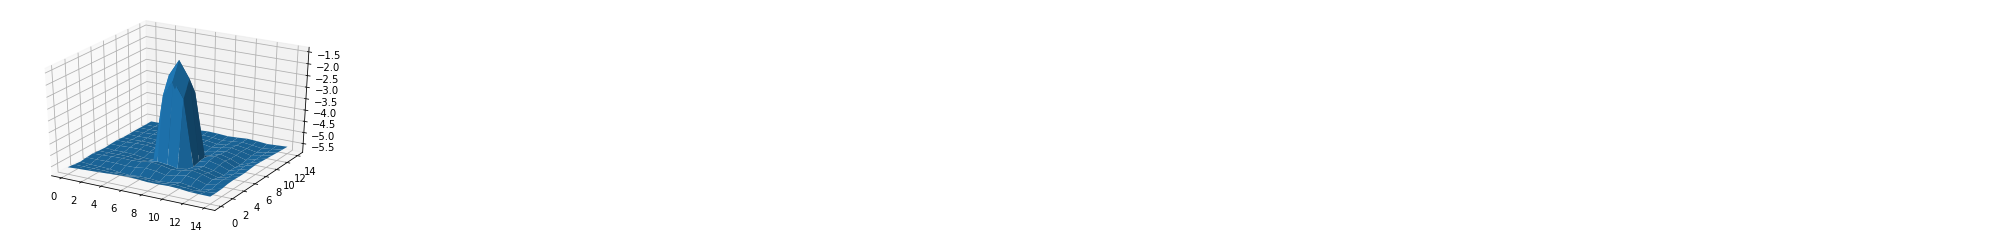

In [23]:
fig=plt.figure()
ax=fig.gca(projection='3d') 
ax.plot_surface(X,Y,np.log(np.abs(basis1)))
plt.show()

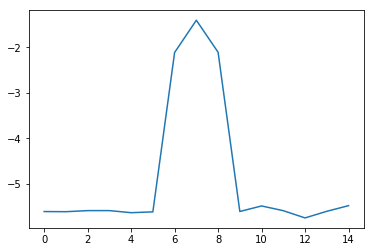

In [24]:
plt.plot(np.log(np.abs(basis1[:][int(sqrtinputsize/2)])))

FEM use basis from global DMM

Energy norm: 
10.038859470012047
L2 norm: 
0.5043002815765
H1 norm: 
5.514745484759367
Energy norm: 
0.6677684946501092
L2 norm: 
1.0086005631529997
H1 norm: 
0.6713471939167983


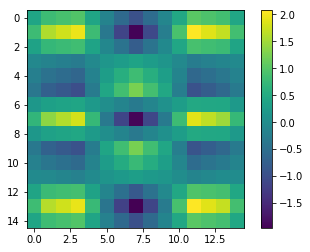

In [25]:

Anew = np.zeros([outputsize,outputsize])
[X1, Y1] = np.meshgrid(np.linspace(0, 1, sqrtinputsize),np.linspace(0, 1, sqrtinputsize))
[X2, Y2] = np.meshgrid(np.linspace(0, 1, sqrtoutputsize),np.linspace(0, 1, sqrtoutputsize))
A = a(X1,Y1)
for i in range(outputsize):
    for j in range(outputsize):
        basisi = Rnew[i][:].reshape([sqrtinputsize,sqrtinputsize])
        basisj = Rnew[j][:].reshape([sqrtinputsize,sqrtinputsize])
        gxbasisi = np.gradient(basisi,axis=0)/h
        gybasisi = np.gradient(basisi,axis=1)/h
        gxbasisj = np.gradient(basisj,axis=0)/h
        gybasisj = np.gradient(basisj,axis=1)/h
        Anew[i][j]=(np.sum(A*gxbasisi*gxbasisj)+np.sum(A*gybasisi*gybasisj))*(H**2)
        
Fnew = np.zeros([outputsize,1])
for i in range(outputsize):
    basisi = Rnew[i][:].reshape([sqrtinputsize,sqrtinputsize])
    F = rightf(X1,Y1)
    Fnew[i]=np.sum(F*basisi)*(H**2)
    
UnewCoarse = np.linalg.solve(Anew,Fnew)
Unew = np.zeros([sqrtinputsize,sqrtinputsize])
for i in range(outputsize):
    basisi = Rnew[i][:].reshape([sqrtinputsize,sqrtinputsize])
    Unew = Unew + UnewCoarse[i]*basisi

plt.imshow(Unew)
plt.colorbar()

UREAL = u_real(X1,Y1).reshape(sqrtinputsize,sqrtinputsize)
deltaU = Unew - UREAL
A = a(X1,Y1)

energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=0),np.gradient(UREAL,h,axis=0)),A)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=1),np.gradient(UREAL,h,axis=1)),A)*(h**2)))
l2norm = np.sqrt((np.sum(UREAL**2))*(h**2))
h1norm = np.sqrt((np.linalg.norm(np.gradient(UREAL,h,axis=0))**2+np.linalg.norm(np.gradient(UREAL,h,axis=1))**2+np.linalg.norm(UREAL)**2)*(h**2))
print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),A)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),A)*(h**2))))
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2)))
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2)))



print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),A)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),A)*(h**2)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.sum(deltaU**2))*(h**2))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2))/h1norm)

In [26]:
import os
os.system("say 'The program has finished, Please check the results'")

0